# Learning the Bridge function


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tqdm.keras import TqdmCallback

In [2]:
def make_model(input_dim, lam=1e-5):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(1, activation='linear', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.summary()

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

def train_model(model, X_train, y_train, y_var, batch_size=128, epochs=100, \
             save_file=False, training_curve=True, val_split=0.1):
    print("Learning MLP model with {} training points".format(len(y_train)))

    try:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, sample_weight=y_var, \
                            validation_split=val_split, verbose=0, callbacks=[TqdmCallback(verbose=1)])
    except KeyboardInterrupt:
        pass
    
    if save_file:
        model.save(save_file)  # creates a HDF5 file 'my_model.h5'
    
    if training_curve:
        # "Loss"
        plt.figure(figsize=(10,8))
        matplotlib.rcParams.update({'font.size': 15})
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
    
    return model

In [3]:
df_train = pd.read_csv("datasets/random-train.csv")
X_train = df_train[["tcf","dcf", "grad_tcf", "grad_dcf"]].values
X_train[:,2] = X_train[:,2] - X_train[:,3]
y_train = df_train[["br_swtch"]].values
y_ivar = (df_train[["err_br_swtch"]].values**-2.).ravel()
# y_ivar = np.ones(len(df_train))

df_test = pd.read_csv("datasets/random-test.csv")
X_test = df_test[["tcf","dcf", "grad_tcf", "grad_dcf"]].values
X_test[:,2] = X_test[:,2] - X_test[:,3]
y_test = df_test[["br_swtch"]].values

In [4]:
# print(np.sum(np.isfinite(y_train)))
# print(y_train.ravel().shape)

In [5]:
local = make_model(2)
non_local = make_model(3)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 44,033
Trainable params: 44,033
Non-trainable params: 0
_________________________________________________________________


In [6]:
# local = load_model("models/local-scaled-small-batch.h5")
# non_local = load_model("models/non-local-scaled.h5")

Learning MLP model with 347376 training points


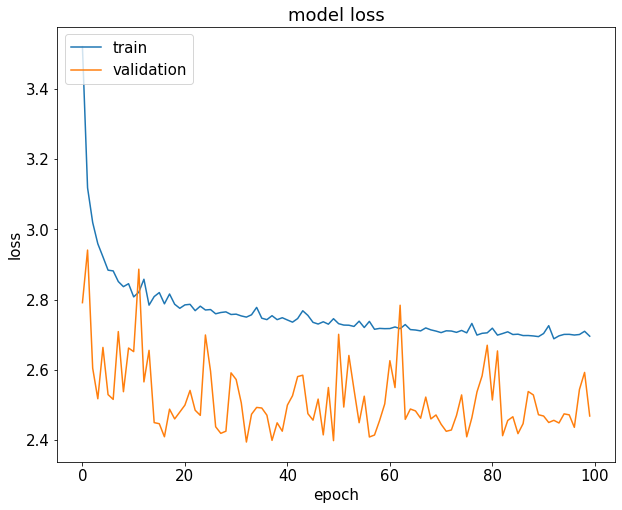

In [7]:
local = train_model(local, X_train[:,0:2], y_train, y_ivar, 
                    epochs=100, save_file="models/local-scaled.h5")

In [ ]:
#y_la = local.predict(X_train[:,0:2])
non_local = train_model(non_local, X_train[:,0:3], y_train, y_ivar, 
                     epochs=100, save_file="models/non-local-scaled.h5")

Learning MLP model with 347376 training points


In [10]:
y_local = local.predict(X_test[:,0:2])
y_non_local = non_local.predict(X_test[:,0:3]) #+ y_local

r2_hnc = r2_score(np.zeros_like(y_test), y_test)
r2_local = r2_score(y_local, y_test)
r2_non_local = r2_score(y_non_local, y_test)

rmse_hnc = np.sqrt(MSE(np.zeros_like(y_test), y_test))
rmse_local = np.sqrt(MSE(y_local, y_test))
rmse_non_local = np.sqrt(MSE(y_non_local, y_test))

print("HNC      : R2: {:.3f}, RMSE {:.3f}".format(r2_hnc, rmse_hnc))
print("Local    : R2: {:.3f}, RMSE {:.3f}".format(r2_local, rmse_local))
print("Non-Local: R2: {:.3f}, RMSE {:.3f}".format(r2_non_local, rmse_non_local))


HNC      : R2: 0.000, RMSE 0.092
Local    : R2: -0.490, RMSE 0.072
Non-Local: R2: 0.824, RMSE 0.036


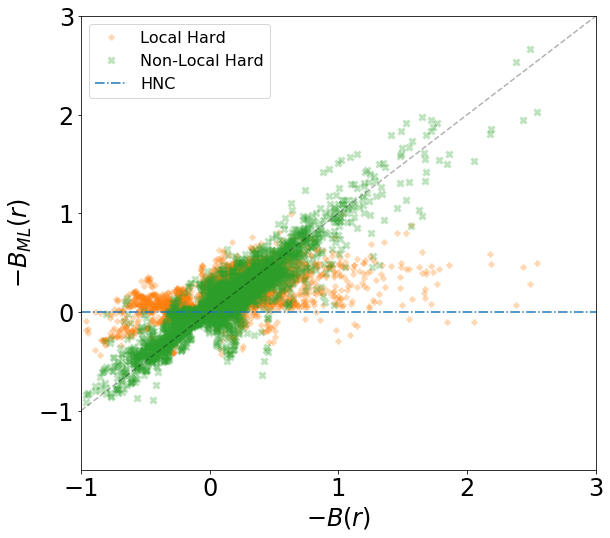

In [11]:
matplotlib.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(figsize=(9,8))

ax.plot(-y_test, -y_local, linestyle="None",
        marker="+", label='Local Hard', alpha=0.3,mew=3, color="tab:orange")

ax.plot(-y_test, -y_non_local, linestyle="None",
        marker="x", label='Non-Local Hard', alpha=0.3,mew=3, color="tab:green")   

ax.plot([-1, 4], [0, 0], linestyle="-.", label='HNC', color="tab:blue")

ax.plot([-2, 3], [-2, 3], linestyle="--", color='k',  alpha=0.3)
ax.legend(markerscale=1, fontsize=16)
ax.set_xlim([-1, 3])
ax.set_ylim([-1.6, 3])
ax.set_xlabel('$-B(r)$')
ax.set_ylabel('$-B_{ML}(r)$')
plt.tight_layout()
plt.savefig("plots/compare_{}.png".format(datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")))
plt.show()
